In [1]:
import pandas as pd
import os
import numpy as np

In [2]:
import pandas as pd
X = pd.read_csv(r'D:\NLP\Dataset_Full.csv')
# Keeping only the neccessary columns
X = X[['Lyrics']]
X.head()

,Lyrics
0,I could feel at the time. There was no way of ...
1,"Take me now, baby, here as I am. Hold me close..."
2,These are. These are days you'll remember. Nev...
3,"A lie to say, ""O my mountain has coal veins an..."
4,Trudging slowly over wet sand. Back to the ben...


In [3]:
import pandas as pd
y = pd.read_csv(r'D:\NLP\Dataset_Full.csv')
# Keeping only the neccessary columns
y = y[['Genre']]
y.head()

,Genre
0,Rock
1,Rock
2,Rock
3,Rock
4,Rock


In [4]:
# Dropping the first column from status dataset
status = pd.get_dummies(y['Genre'], drop_first = True)

# Adding the status to the original y yframe
y = pd.concat([y, status], axis = 1)

# Dropping 'Property_Area' as we have created the dummies for it
y.drop(['Genre'], axis = 1, inplace = True)

y.head()

,Pop,Rock
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [5]:
X.head()

,Lyrics
0,I could feel at the time. There was no way of ...
1,"Take me now, baby, here as I am. Hold me close..."
2,These are. These are days you'll remember. Nev...
3,"A lie to say, ""O my mountain has coal veins an..."
4,Trudging slowly over wet sand. Back to the ben...


In [6]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K


def get_model():
    """Define the model."""
    model = Sequential()
    model.add(LSTM(300, dropout=0.5, recurrent_dropout=0.4,
              input_shape=[1, 29568], return_sequences=True))
    #model.add(LSTM(300, dropout=0.5, recurrent_dropout=0.4, return_sequences=True))
    model.add(LSTM(200, dropout=0.5, recurrent_dropout=0.4, return_sequences=True))
    model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.4, return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model


In [7]:
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
#from gensim.models import Word2Vec
from nltk.tokenize import PunktSentenceTokenizer
from nltk.tokenize import sent_tokenize
nltk.download('punkt')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\welcome\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
import tensorflow_hub as hub

use= hub.load("https://tfhub.dev/google/nnlm-en-dim128/2")
aa=[]

In [9]:
def essay_to_wordlist(essay_v, remove_stopwords):
    """Remove the tagged labels and word tokenize the sentence."""
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return (words)
def essay_to_sentences(essay_v, remove_stopwords):
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    #tokennizer=PunktSentenceTokenizer(english.pickle)
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append((raw_sentence))
    #print(sentences)
    return sentences
def makeFeatureVec(words, num_features,n):
    """Make Feature Vector from the words list of an Essay."""
    featureVec = np.zeros((n,num_features),dtype="float32")
    featureVec = np.add(featureVec,use(words))   
    #print(featureVec.shape)     
    #featureVec = np.divide(featureVec,num_words)
    return featureVec
def getAvgFeatureVecs(essays, num_features,aa):
    """Main function to generate the word vectors for word2vec model."""
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features*231),dtype="float32")
    #essayFeatureVecs=[]
    #print(num_features*96)
    for essay in essays:
        #essayFeatureVecs.insert(counter,makeFeatureVec(essay,num_features,aa[counter]))
        arr=makeFeatureVec(essay, num_features,aa[counter]).flatten()
        ss=(num_features*231)-len(arr)
        arr1=np.pad(arr,(0,ss),'constant', constant_values=(0, 0))
        #print(np.add(arr1,np.zeros(num_features*np.max(aa))))
        essayFeatureVecs[counter] = np.add(arr1,np.zeros((num_features*231),dtype="float"))
        #makeFeatureVec(essay, num_features,aa[counter]).flatten()
        #print(essayFeatureVecs[0])
        counter = counter + 1
    return essayFeatureVecs

In [14]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score
import tensorflow as tf
from sklearn.model_selection import train_test_split

cv = KFold(n_splits = 5, shuffle = True)
results = []
y_pred_list = []

count = 1
for traincv, testcv in cv.split(X):
    print("\n--------Fold {}--------\n".format(count))
    X_test, X_train, y_test, y_train = X.iloc[testcv], X.iloc[traincv], y.iloc[testcv], y.iloc[traincv]
    #print(y_train)
    train_essays = X_train['Lyrics']
    test_essays = X_test['Lyrics']
    num_features = 128
    min_word_count = 40
    num_workers = 4
    context = 10
    downsampling = 1e-3
    clean_train_essays = []
    clean_test_essays=[]
    #essays=train_essays
    sentences=[]
    l1=[]
    l2=[]
    for essay in train_essays:
      sentences += essay_to_sentences(essay, remove_stopwords = False)
      #print(sentences)
    for essay in test_essays:
      sentences += essay_to_sentences(essay, remove_stopwords = False)
    for essay_v in train_essays:
      l1.append(len(sent_tokenize(essay_v)))
      clean_train_essays.append(essay_to_sentences(essay_v, remove_stopwords=True))
      #print(clean_train_essays)
    a=np.array(l1)
    print(max(a))
    trainDataVecs = getAvgFeatureVecs(clean_train_essays, num_features,a)
    for essay_v in test_essays:
      l2.append(len(sent_tokenize(essay_v)))
      clean_test_essays.append(essay_to_sentences(essay_v, remove_stopwords=True))
    b=np.array(l2)
    testDataVecs=getAvgFeatureVecs(clean_test_essays, num_features,b)
    trainDataVecs=np.array(trainDataVecs)
    testDataVecs = np.array(testDataVecs)
    trainDataVecs=np.reshape(trainDataVecs,(trainDataVecs.shape[0],1,trainDataVecs.shape[1]))
    testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
    #print(b)
    #lstm_model = get_model()
    X_train, X_val, y_train, y_val = train_test_split(trainDataVecs, y_train, test_size=0.2, random_state=1)
    lstm_model = get_model()
    history=lstm_model.fit(X_train, y_train, batch_size=64, epochs=35,validation_data=(X_val, y_val))
    #history=lstm_model.fit(trainDataVecs, y_train, batch_size=90, epochs=15)
    y_pred=(lstm_model.predict(testDataVecs))
    #print(y_pred)
    # Save any one of the 5 models.
    #if count == 6:
      #break
         #lstm_model.save('./model_weights/final_lstm.h5')
    
    # Round y_pred to the nearest integer.
    y_pred = np.around(y_pred)
    #print(y_pred)
    
    # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
    #result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
    #print("Kappa Score: {}".format(result))
    #results.append(result)

    #count += 1
   
     


--------Fold 1--------

231
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 1, 300)            35842800  
                                                                 
 lstm_21 (LSTM)              (None, 1, 200)            400800    
                                                                 
 lstm_22 (LSTM)              (None, 1, 100)            120400    
                                                                 
 lstm_23 (LSTM)              (None, 64)                42240     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                                 
Total params: 36,406,370


In [15]:
lstm_model.save('./model_weights/bert_lstm.h5')

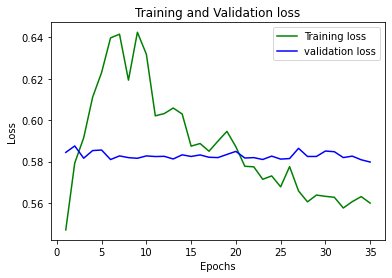

In [16]:
from matplotlib import pyplot as plt
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,36)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

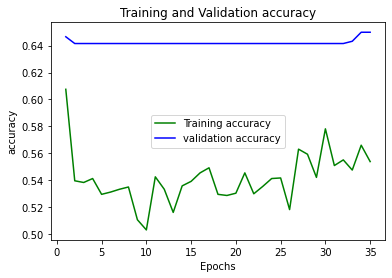

In [17]:
from matplotlib import pyplot as plt
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
epochs = range(1,36)
plt.plot(epochs, accuracy_train, 'g', label='Training accuracy')
plt.plot(epochs, accuracy_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()